# Dependencies 

## Imports 

In [2]:
# imports 
# base python
import os
import copy
import re
from sys import getsizeof
import random

# scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt,mpld3
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import seaborn as sns
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import preprocessing
import matplotlib.tri as tri

plt.rcParams["figure.figsize"] = (20,7)

#ase
from ase.io import gen, vasp, xyz, extxyz, dftb
from ase.io.dftb import read_dftb_velocities, write_dftb_velocities
from ase.calculators.dftb import Dftb
from ase import Atoms, Atom
from ase.constraints import FixAtoms
from ase.visualize import view
from ase.build import make_supercell
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
import nglview
from ase.geometry.analysis import Analysis

#dscribe
from dscribe.descriptors import SOAP
from dscribe.descriptors import MBTR
from dscribe.kernels import REMatchKernel
from dscribe.kernels import AverageKernel

from sklearn import preprocessing


#quippy 
from ase.build import bulk
from ase.optimize import LBFGS
from ase.visualize import view
from quippy.potential import Potential


#misc
import similaritymeasures


_ColormakerRegistry()

## Functions

In [3]:
def show_atoms_grid(data, rotation = '-0x,0y,0z', save= False, filename = 'grid_configs'):
    '''
    Where data is list of Atoms objects
    '''
    dim = int(np.ceil(np.sqrt(len(data))))
    fig, axarr = plt.subplots(dim, dim, figsize=(25, 25))
    for i, config in enumerate(data):
        plot_atoms(config, axarr[i%dim,i//dim], rotation = rotation)
    if save:
        fig.savefig(filename + ".png")
        
def normalize(y,x):
    """
    Takes y, x of data and returns normalized y
    """
    return y/np.trapz(y,x)

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6.24E18 * 0.5 * 1.66E-27*39.95*(v_tot*1E5)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6.24E18 * 0.5 * 1.66E-27*39.95))/1E5

## Structures

In [4]:
mef = vasp.read_vasp("reference_files/CONTCAR_mef")
cf4 = vasp.read_vasp("reference_files/CONTCAR_cf4")
amorphous = vasp.read_vasp("reference_files/CONTCAR_amorphous_cubic")
xtl_n = vasp.read_vasp("reference_files/CONTCAR_nrich")
xtl_si = vasp.read_vasp("reference_files/CONTCAR_sirich")
xtl2x2 = gen.read_gen("reference_files/2x2xtl.gen")
xtl2x2_sifterm = gen.read_gen("reference_files/2x2xtl_sifterm.gen")
heavy_bomb = vasp.read_vasp("reference_files/CONTCAR_heavy_bombard")
bulk222 = vasp.read_vasp("reference_files/CONTCAR_222bulk")
annealed = vasp.read_vasp("reference_files/CONTCAR_annealed_unitcell")

# Data read

Read in final geometry files

In [5]:
datadir = "../bomb/" #bare bombardment, v0.13 = 35.0 eV, 0.135 = 37.7 eV, .14 = 40.55 eV
geometries = {}
for i in os.listdir(datadir):
    if ".gen" in i:
        key = re.search(r"\d+-\d+", i)
#         key = re.search(r"\d+", i)
        if key:
            key = key.group(0)
#             print(key)
            geometries[key] =  gen.read_gen(datadir + i)

Process velocities, if necessary:

In [15]:
velos = {}
for i in os.listdir(datadir):
    if "velo" in i:
        key = re.search(r"\d+-\d+", i)
        if key:
            key = key.group(0)
            velos[key] = pd.read_csv(datadir + i, header = None, dtype = float, sep = "\s+")

Process `steps` file, if necessary (contains runID and steps on each row, space separated)

We'll remove the errant runs from the `geometries` dictionary and can assess them individually as part of an `errors` dictionary.

In [16]:
numsteps = 990

steps = pd.read_csv(datadir + "steps", sep = "\s+", index_col = 0)
steps.head()

,steps
run,
0-0,999
0-1,999
0-2,999
0-3,999
0-4,999


Remove runs that didn't go to completion, log keys of runs that failed:

In [17]:
try:
    errors
except NameError:
    errors = {}
    for key in steps.index:
        if steps.loc[key, "steps"] < numsteps:
            if key in geometries.keys():
                errors[key] = geometries[key]
                del geometries[key]

Number of successful runs and unsuccessful runs:

In [18]:
len(geometries.items()), len(errors.items())

(170, 0)

View geometries, if desired:

In [6]:
view([geometries[key] for key in geometries.keys()])

In [36]:
# temp = gen.read_gen("../bomb/output0-8.gen")
temp = xyz.read_xyz("../geom.out.xyz", index = 555)
temp = list(temp)[0]
temp.cell = xtl2x2.cell
view(temp)
temp.wrap()
view(temp)
# xyz.write_xyz("../tempoutput.xyz", temp)
# vasp.write_vasp("../POSCAR", temp, sort = True, vasp5 = True)

View specific geometry

In [47]:
KE(.122)

30.7963415136

In [31]:
tempkey = list(geometries.keys())[52]
print(tempkey)
outstruct = geometries[tempkey].copy()
view(outstruct)

9-5


Count number of Si

In [87]:
for key, value in geometries.items():
    if (np.sum(value.numbers == Atom('Si').number) != 96):
        print(key, np.sum(value.numbers == Atom('Si').number))

4-6 95
3-8 95
8-10 95
6-16 95
8-4 95
9-9 95


Sort atoms by height

In [44]:
print(outstruct)
# view(outstruct)
tempstruct = Atoms(sorted(outstruct, key = lambda atom: atom.position[2]))
del outstruct[[atom.index for atom in outstruct]]
print(outstruct)
outstruct += tempstruct
print(outstruct)
view(outstruct)

Atoms(symbols='C156H184ArO20', pbc=True, cell=[10.0, 60.0, 20.0])
Atoms(symbols='', pbc=True, cell=[10.0, 60.0, 20.0])
Atoms(symbols='C156H184ArO20', pbc=True, cell=[10.0, 60.0, 20.0])


Write to VASP if needed

In [15]:
outstruct.constraints = FixAtoms([atom.index for atom in outstruct if atom.position[2] < 2 and atom.symbol != "H"])
view(outstruct)
vasp.write_vasp("../CONTCARtemp", outstruct, sort = True, vasp5 = True)

View errored runs, if desired:

In [16]:
view(errors.values())

In [17]:
errors.keys()

dict_keys([])

In [18]:
view(errors['9-16'])

KeyError: '9-16'

In [12]:
analyses = {key: Analysis(geom) for key, geom in geometries.items()}

# RDF analysis

In [30]:
def averaged_rdfs(datadir, v):
    geometries = {}
    for i in os.listdir(datadir):
        if ".gen" in i:
            key = re.search(r"\d+-\d+", i)
            if key:
                key = key.group(0)
                geometries[key] =  gen.read_gen(datadir + i)
    structs = [geometries[key] for key in geometries.keys()]

    structAnal = Analysis(structs)

    rdfs = structAnal.get_rdf(rmax = 5, nbins = 100, elements = ["Si", "N"], return_dists=True)

    xtl_y, xtl_x = Analysis(xtl2x2).get_rdf(rmax = 5, 
                                         nbins = 100, 
                                         elements = ["Si", "N"], 
                                         return_dists = True)[0]
    xtl_y = normalize(xtl_y, xtl_x)

    amorphous_y, amorphous_x = Analysis(amorphous).get_rdf(rmax = 5, 
                                         nbins = 100, 
                                         elements = ["Si", "N"], 
                                         return_dists = True)[0]
    amorphous_y = normalize(amorphous_y, amorphous_x)

    rdfs = np.array(rdfs)
    data_y_rdfs, data_x_rdf = rdfs[:,0], rdfs[:, 1][0] # x arrays are all identical 
    data_y_rdfs = np.array([normalize(i, data_x_rdf) for i in data_y_rdfs])
    data_rdf_mean_y = np.mean(data_y_rdfs, axis=0)
    data_rdf_sd_y = np.std(data_y_rdfs, axis=0)


    plt.plot(xtl_x, xtl_y, label = "crystalline case")
    plt.plot(amorphous_x, amorphous_y, label = "amorphous case (T=100K)")

    plt.plot(data_x_rdf, data_rdf_mean_y, label = "average bombarded case")

    plt.fill_between(data_x_rdf, data_rdf_mean_y - 1.96*data_rdf_sd_y, data_rdf_mean_y + 1.96*data_rdf_sd_y,
                     color='gray', alpha=0.2)

    plt.xlim(1, 5)
    plt.title("Random bombardment of (2x2) slab, v={}, KE = {} eV".format(v, round(KE(v),2)), 
              fontsize = "x-large")
    plt.legend(fontsize = 'x-large');
    
    return data_x_rdf, data_rdf_mean_y, data_rdf_sd_y



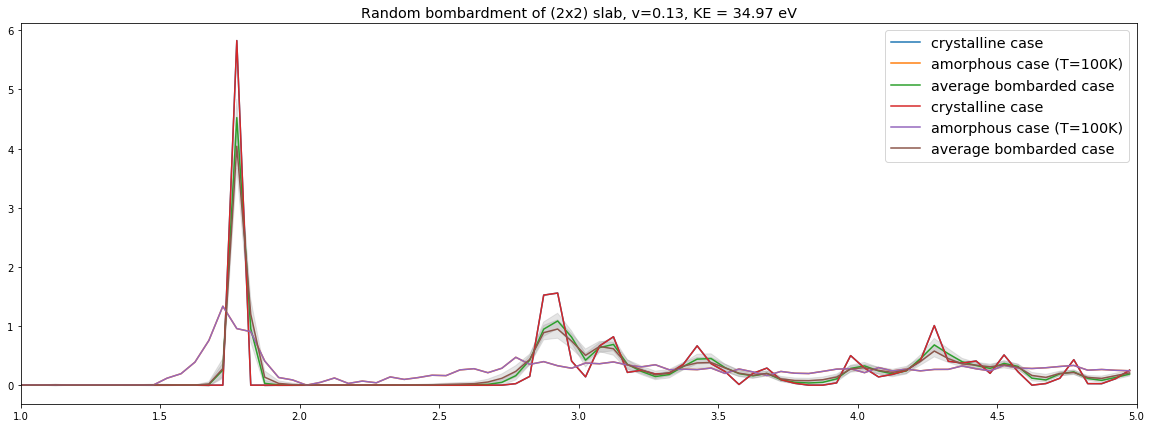

In [32]:
rdf_data = [averaged_rdfs(i, .13) for i in ["../bomb0/", "../bomb6/"]]

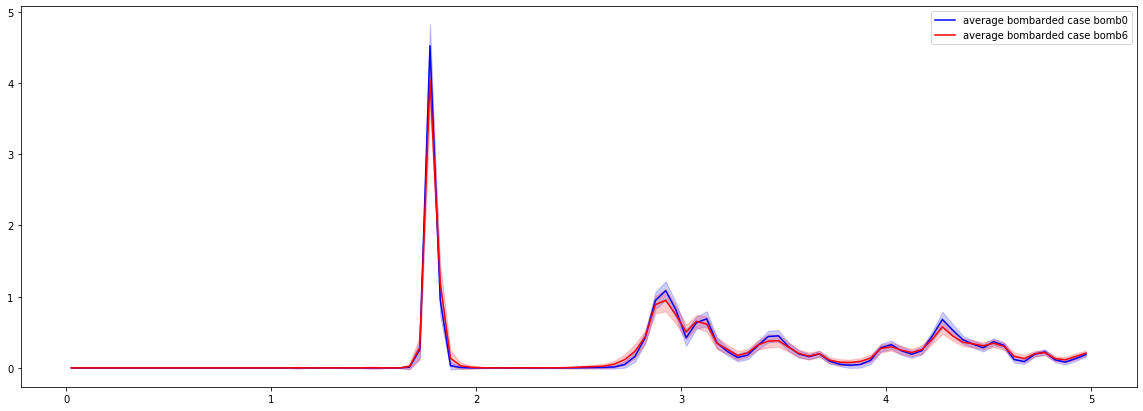

In [41]:
i = 0
colors = ["blue", "red"]
labels = ["average bombarded case %s" % s for s in ["bomb0", "bomb6"]]
for x,y,sd in rdf_data:
    plt.plot(x, y, label = labels[i], color = colors[i])
    plt.fill_between(x, y - 1.96*sd, y + 1.96*sd, color=colors[i], alpha=0.2)
    i += 1
plt.legend();

In [10]:
rdfs = np.array([i.get_rdf(rmax=5,
                             nbins = 100, 
                             elements = ["Si", "N"], 
                             return_dists = True)[0]
        for i in analyses
       ])

In [12]:
data_y_rdfs, data_x_rdf = rdfs[:,0], rdfs[:, 1][0] # x arrays are all identical 
data_y_rdfs = np.array([normalize(i, data_x_rdf) for i in data_y_rdfs])
data_rdf_mean_y = np.mean(data_y_rdfs, axis=0)
data_rdf_sd_y = np.std(data_y_rdfs, axis=0)

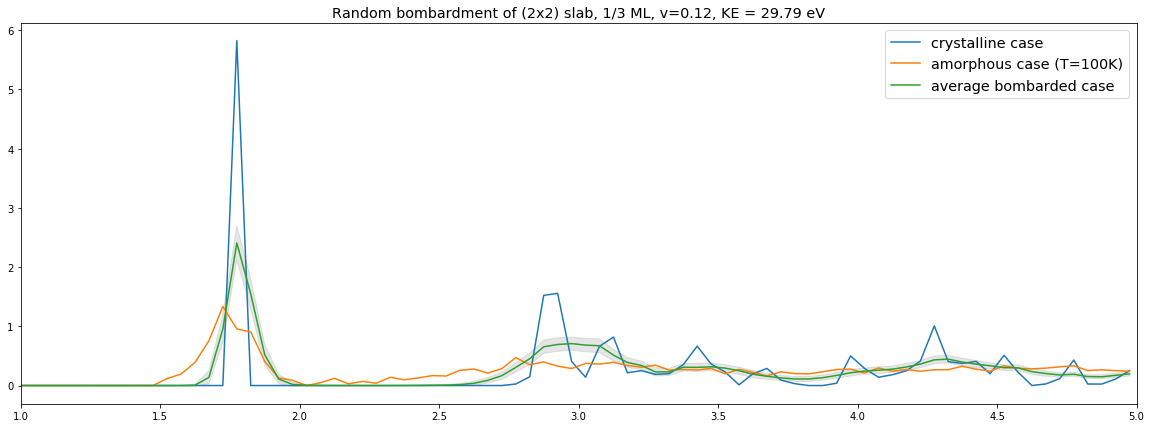

In [13]:
plt.plot(xtl_x, xtl_y, label = "crystalline case")
plt.plot(amorphous_x, amorphous_y, label = "amorphous case (T=100K)")

plt.plot(data_x_rdf, data_rdf_mean_y, label = "average bombarded case")

plt.fill_between(data_x_rdf, data_rdf_mean_y - 1.96*data_rdf_sd_y, data_rdf_mean_y + 1.96*data_rdf_sd_y,
                 color='gray', alpha=0.2)

plt.xlim(1, 5)
v = 0.12
plt.title("Random bombardment of (2x2) slab, 1/3 ML, v={}, KE = {} eV".format(v, round(KE(v),2)), 
          fontsize = "x-large")
plt.legend(fontsize = 'x-large');

In [14]:
view(finalGeoms[random.choice(np.arange(len(finalGeoms)))])

# Bond analysis

In [16]:
siArBonds = {key: i.get_bonds("Ar", "Si")[0] for key, i in analyses.items()}

<BarContainer object of 170 artists>

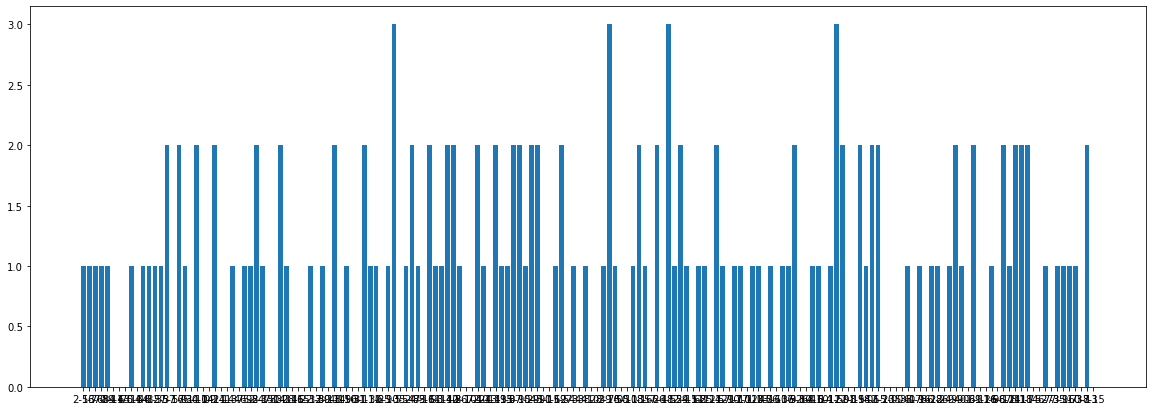

In [17]:
plt.bar([key for key in siArBonds.keys()], 
         [len(siArBonds[key]) for key in siArBonds.keys()])

Pick random runs to assess using DFT.

In [18]:
np.random.seed(429)
embeddedAr = [key for key in siArBonds.keys() if len(siArBonds[key]) > 0]
choices = np.random.choice(embeddedAr, size = 5, replace = False)
choices

array(['4-1', '9-12', '0-12', '5-12', '0-3'], dtype='<U4')

Convert the selected geometries to VASP format

In [26]:
def fixbottom(src, zcutoff = 2):
    '''
    Utility to fix bottom layer, for gen -> POSCAR conversions
    Takes in a structure, and modifies it such that the bottom has a cutoff
    '''
    cutoff_elems = ['Si', 'N']
    cutoff_atoms = [atom for atom in src if 
     atom.symbol in cutoff_elems and atom.position[2] < zcutoff]
    cutoff_indices = [atom.index for atom in cutoff_atoms]

    src.constraints = [FixAtoms(indices = cutoff_indices)]

In [23]:
for i, key in enumerate(choices):
    vasp.write_vasp("../POSCAR" + str(i), geometries[key], label = key, vasp5=True)

view([geometries[key] for key in choices])

In [49]:
def maketrimmedgeoms(datadir1, datadir2, zoffset = 4, searchpattern = r"\d+-\d+", filename = "output", 
                     elements = ['Si', 'N', 'H', 'Ar'], minz = 0.1):
    '''
    Trim geometries based on both final frame of NVE MD (templates) and equlibration step (geometries). 
    TODO: VELOS PART NEEDS UPDATING
    '''
    templates = {}
    for i in os.listdir(datadir1):
        if filename in i:
            key = re.search(searchpattern, i)
            if key:
                key = key.group(0)
                templates[key] =  gen.read_gen(datadir1 + i)

    geometries = {}
    for i in os.listdir(datadir2):
        if filename in i:
            key = re.search(searchpattern, i)
            if key:
                key = key.group(0)
                templates[key] =  gen.read_gen(datadir2 + i)

    zcutoff = max([i.position[2] for i in xtl2x2]) + zoffset #approx H bond range

    trimmedgeoms = dict()
    trimmedvelos = dict()

    removedspecies = dict()

    for key, geom in templates.items(): 
        aboveZindices = set()
        belowZindices = set()
        otherindices = set()
        nearbyatoms = set()
        removedatoms = {key:0 for key in elements}
        for atom in geom:
            #checks for bounds at end of equilibration step
            if atom.position[2] > zcutoff:
                aboveZindices.add(atom.index)
            elif atom.position[2] < minz:
                belowZindices.add(atom.index)
            #checks for bounds at end of NVE step
            elif templates[key][atom.index].position[2] > zcutoff:
                aboveZindices.add(atom.index)
            elif templates[key][atom.index].position[2] < minz: #hardcoded
                belowZindices.add(atom.index)
            else:
                otherindices.add(atom.index)
        # iteration through geom once guarantees uniqueness in aboveZindices and otherindices 

        for i in aboveZindices:
            _dists = geom.get_distances(i, list(otherindices))
            nearbyatoms.update(np.array(list(otherindices))[_dists < 2]) 
            # add indices where distance to i is less than 2
        atomstoremove = aboveZindices.union(nearbyatoms).union(belowZindices)

        for idx in atomstoremove:
            removedatoms[geom[idx].symbol] += 1

        geomcopy = templates[key].copy()
        geomcopy.wrap()
        del geomcopy[[atom.index for atom in geomcopy if atom.index in atomstoremove]]

        removedspecies[key] = pd.Series(removedatoms)
        trimmedgeoms[key] = geomcopy

    # collect all removed species series into a df
    removedspecies = pd.DataFrame(removedspecies)
    return trimmedgeoms, trimmedvelos, removedspecies

In [51]:
trimmedgeoms, trimmedvelos, removedspecies = maketrimmedgeoms(datadir, datadir)

In [62]:
for i, key in enumerate(choices):
    fixbottom(trimmedgeoms[key])
    vasp.write_vasp("../POSCAR" + str(i), trimmedgeoms[key], label = key, vasp5=True, sort = True)
    gen.write_gen("../input%d.gen" % i, trimmedgeoms[key])

In [54]:
choices

array(['4-1', '9-12', '0-12', '5-12', '0-3'], dtype='<U4')

In [71]:
temp = xtl2x2.copy()
add_adsorbate(temp, "Ar", height = 7)
fixbottom(temp)
vasp.write_vasp("../POSCAR", temp, vasp5=True, sort = True)

In [56]:
removedspecies[choices]

,4-1,9-12,0-12,5-12,0-3
Si,0,0,0,0,0
N,2,0,0,0,1
H,2,0,0,0,2
Ar,0,0,0,0,0


In [53]:
np.sum([len(siArBonds[key]) != 0 for key in siArBonds.keys()])/len([len(siArBonds[key]) == 0 for key in siArBonds.keys()])

0.6235294117647059

In [54]:
sinBonds = [i.get_bonds("N", "Si")[0] for i in analyses]

sinBondCounts = np.array([len(i) for i in sinBonds])

AttributeError: 'str' object has no attribute 'get_bonds'

In [55]:
plt.plot(np.arange(len(sinBonds)), sinBondCounts)

NameError: name 'sinBonds' is not defined

In [56]:
temp = [geom.copy() for i,geom in enumerate(finalGeoms) if i in np.where(sinBondCounts < 372)[0]]
[i.wrap() for i in temp]
view(temp)

NameError: name 'finalGeoms' is not defined

In [57]:
nhBonds = [i.get_bonds("N", "H")[0] for i in analyses]

nhBondCounts = np.array([len(i) for i in nhBonds])

AttributeError: 'str' object has no attribute 'get_bonds'

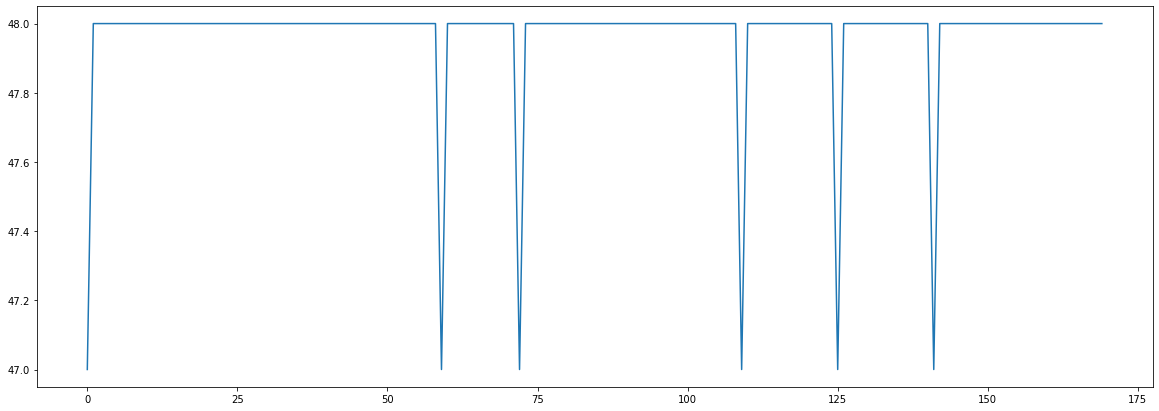

In [18]:
plt.plot(np.arange(len(nhBonds)), nhBondCounts)

Which runs had nonstandard results?

In [19]:
np.where(nhBondCounts < 48)[0]

array([  0,  59,  72, 109, 125, 141])

In [58]:
view([geom for i,geom in enumerate(finalGeoms) if i in np.where(nhBondCounts < 48)[0]])

Get labels of trajectories with nonunity percent NH bonds

In [47]:
np.array([i for i in results.keys()])[np.where(nhBondCounts < 48)[0]]

array(['0-0', '3-8', '4-4', '6-7', '7-6', '8-5'], dtype='<U4')

Finding which nitrogen(s) had the H removed:

In [50]:
nBondCounts = []
for geomnhBonds, geomsinBonds, finalGeom in zip(nhBonds, sinBonds, finalGeoms):
    nIndices = [atom.index for atom in finalGeom if atom.symbol == "N"]
    nBondCount = {}
    for nhbond in geomnhBonds:
        for atom in nhbond:
            if atom in nIndices:
                nBondCount[atom] = nBondCount.get(atom, 0) + 1
    for sinbond in geomsinBonds:
        for atom in sinbond:
            if atom in nIndices:
                nBondCount[atom] = nBondCount.get(atom, 0) + 1
    nBondCounts += [nBondCount] 

In [57]:
temp = [i.copy() for i in finalGeoms]
[i.wrap() for i in temp]
tempcharges = [[nBondCounts_i.get(i, -1) for i in range(len(temp_i))] 
               for temp_i,nBondCounts_i in zip(temp, nBondCounts)]
[i.set_initial_charges(tempcharges_i) for i, tempcharges_i in zip(temp, tempcharges)]
view(temp)

# SOAP analysis

In [11]:
desc = SOAP(species=[7, 14], 
             rcut=5.0, 
             nmax=10, 
             lmax=9, 
             sigma=0.1, 
             periodic=True, 
             crossover=True, 
             sparse=False)

bulkfeatures = preprocessing.normalize(desc.create(bulk222))

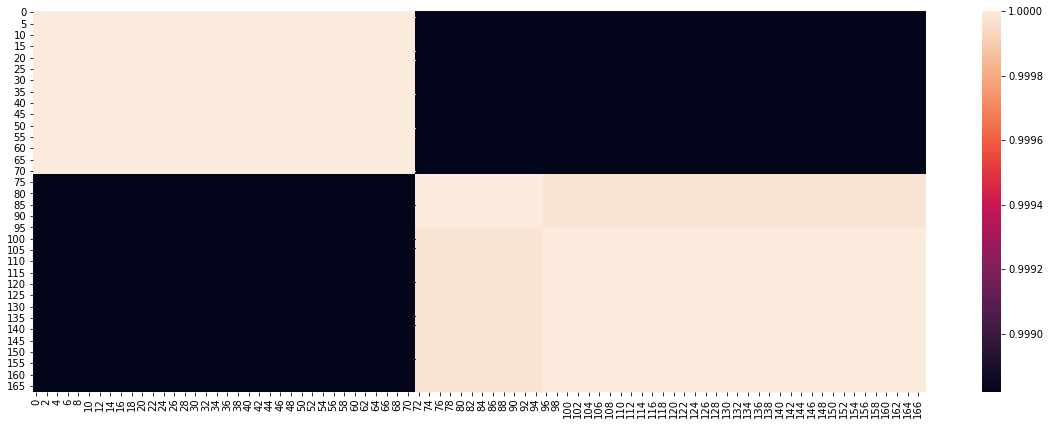

In [12]:
ax = sns.heatmap(rbf_kernel(bulkfeatures, bulkfeatures))

Create Si and N reference arrays

In [15]:
siref = bulkfeatures[0].reshape(1, -1)
nref = bulkfeatures[-1].reshape(1, -1)

Assessing the heavily bombarded structure:

In [14]:
temp = heavy_bomb.copy()
del temp[[atom.index for atom in temp if atom.symbol not in ["Si", "N"]]]

heavybombSisim = rbf_kernel(siref, preprocessing.normalize(desc.create(temp)))[0]
heavybombNsim = rbf_kernel(nref, preprocessing.normalize(desc.create(temp)))[0]

charges = []

for i, atom in enumerate(temp):    
    if atom.symbol == "Si":
        charges.append(heavybombSisim[i])
    elif atom.symbol == "N":
        charges.append(heavybombNsim[i])
temp.set_initial_charges(charges)
view(temp)

Assessing an annealed structure:

In [2]:
temp = annealed.copy()
del temp[[atom.index for atom in temp if atom.symbol not in ["Si", "N"]]]

heavybombSisim = rbf_kernel(siref, preprocessing.normalize(desc.create(temp)))[0]
heavybombNsim = rbf_kernel(nref, preprocessing.normalize(desc.create(temp)))[0]

charges = []

for i, atom in enumerate(temp):    
    if atom.symbol == "Si":
        charges.append(heavybombSisim[i])
    elif atom.symbol == "N":
        charges.append(heavybombNsim[i])
temp.set_initial_charges(charges)
view(temp)

NameError: name 'annealed' is not defined

Assessing all bombarded structures in dataset

In [1]:
soapGeoms = 
for atoms in soapGeoms:
    del atoms[[atom.index for atom in atoms if atom.symbol not in ['Si', 'N']]]

SyntaxError: invalid syntax (<ipython-input-1-d0e89c5575c5>, line 1)

In [ ]:
vizStructs = []
for i, geom in enumerate(geometries):
    temp = geom.copy()
    charges = []
    for j, atom in enumerate(temp):
        if atom.symbol == "Si":
            charges.append(siSimilarities[i][j])
        elif atom.symbol == "N":
            charges.append(nSimilarities[i][j])
        else:
            charges.append(0)
    charges = np.array(charges)
    del temp[[atom.index for atom in geom if atom.symbol not in ['Si', 'N']]]
    charges = charges[[atom.index for atom in geom if atom.symbol in ['Si', 'N']]]
    temp.set_initial_charges(charges)
    vizStructs.append(temp)

# Height analysis (Z distribution function)

In [43]:
def zDist(atoms):
    try:
        zvals = atoms.cell
    except:
        print('heh')

In [41]:
path1 = "../hterm_final.gen"
path2 = "../amorphous_bombed_0.gen"
test1 = gen.read_gen(path1).copy()
test2 = gen.read_gen(path2).copy()
del test1[[atom.index for atom in test1 if atom.symbol not in ["Si", "N"]]]
del test2[[atom.index for atom in test2 if atom.symbol not in ["Si", "N"]]]

Text(0.5, 1.0, 'Z distribution of Si, N atoms in amorphous bombardment')

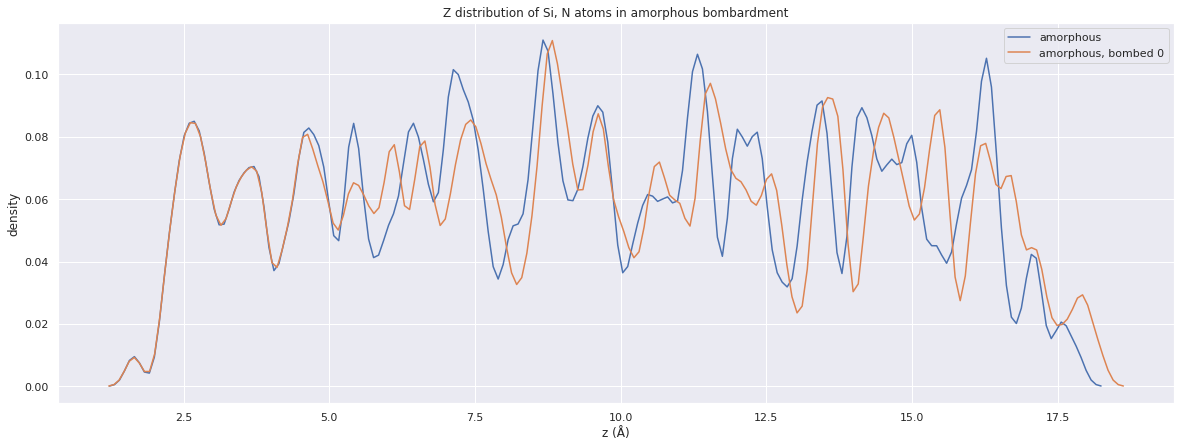

In [45]:
import seaborn as sns
sns.set_theme(style="darkgrid")
zs1 = [atom.z for atom in test1]
zs2= [atom.z for atom in test2]
# plt.hist(zs1,bins = np.arange(0, 14, .2), alpha = 0.7, label = 'bomb0')
# plt.hist(zs2,bins = np.arange(0, 14, .2), alpha = 0.7, label = 'bomb6')
sns.kdeplot(zs1, bw_adjust = 0.1, label = 'amorphous')
sns.kdeplot(zs2, bw_adjust = 0.1, label = 'amorphous, bombed 0')
plt.legend()
plt.xlabel("z (Å)")
plt.ylabel("density")
plt.title("Z distribution of Si, N atoms in amorphous bombardment")

# Height analysis (removal)

In [13]:
zcutoff - 4

NameError: name 'zcutoff' is not defined

In [29]:
# this should be the output of the bombardment *before* quench and eq
templates = {}
templatefile = "../bomb/"
for i in os.listdir(templatefile):
    if ".gen" in i:
        key = re.search(r"\d+-\d+", i)
        if key:
            key = key.group(0)
            templates[key] =  gen.read_gen(templatefile + i)

Below code finds atoms that are at least 4 Å above the surface (or below the slab) at 1 ps after impact and removes them from geometry after quenching and equilibration. 

In [30]:
# to account for seed behavior from first numssofar sets of runs
# numssofar can also be interpreted as = current run seeding for
numsofar = 7
np.random.seed(429)
for i in range(numsofar):
    for i in range(170):
        x_rand, y_rand, z_rand = np.append(np.random.random(size = 2), 0)

In [31]:
zcutoff = max([i.position[2] for i in xtl2x2]) + 4 #approx H bond range for N:H surf
# zcutoff = max([i.position[2] for i in xtl2x2_sifterm]) + 4 # approx H bond range for Si:F surf
# zcutoff = max([i.position[2] for i in gen.read_gen("../geom.end.gen")]) + 4 # approx H bond range

trimmedgeoms = dict()
trimmedvelos = dict()

removedspecies = dict()

for key, geom in geometries.items(): 
    aboveZindices = set()
    belowZindices = set()
    otherindices = set()
    nearbyatoms = set()
    removedatoms = {'Si': 0, 'N': 0, 'H': 0, 'Ar': 0, 'F':0 }
    for atom in geom:
        if atom.position[2] > zcutoff:
            aboveZindices.add(atom.index)
        elif atom.position[2] < .1:
            belowZindices.add(atom.index)
#         elif templates[key][atom.index].position[2] > zcutoff:
#             aboveZindices.add(atom.index)
        elif templates[key][atom.index].position[2] < .1:
            belowZindices.add(atom.index)
        else:
            otherindices.add(atom.index)
    # iteration through geom once guarantees uniqueness in aboveZindices and otherindices 
    
    for i in aboveZindices:
        _dists = geom.get_distances(i, list(otherindices))
        nearbyatoms.update(np.array(list(otherindices))[_dists < 2]) 
        # add indices where distance to i is less than 2
    atomstoremove = aboveZindices.union(nearbyatoms).union(belowZindices)
    
    for idx in atomstoremove:
        removedatoms[geom[idx].symbol] += 1
    
    geomcopy = geom.copy()
#     geomcopy.wrap()
    del geomcopy[[atom.index for atom in geomcopy if atom.index in atomstoremove]]
    
    # add in new Ar atom
    
    x_rand, y_rand, z_rand = geomcopy.cell.cartesian_positions(np.append(np.random.random(size = 2), 0))
    add_adsorbate(geomcopy, adsorbate = 'Ar', height = 7, position = (x_rand, y_rand))
    removedspecies[key] = pd.Series(removedatoms)
    trimmedgeoms[key] = geomcopy
    trimmedvelos[key] = velos[key][[i not in atomstoremove for i in np.arange(len(velos[key]))]]
    trimmedvelos[key] = trimmedvelos[key].append(pd.Series([0, 0, -130]), ignore_index=True)
    
# collect all removed species series into a df
removedspecies = pd.DataFrame(removedspecies)

In [32]:
removedspecies

,2-13,5-7,6-6,7-8,0-4,8-14,9-13,6-0,7-16,5-14,...,4-2,6-7,7-3,7-5,3-16,9-7,1-3,0-8,3-13,7-15
Si,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
print("total number of each species removed:")
removedspecies.sum(axis = 1)

total number of each species removed:


Si    0
N     0
H     0
Ar    1
F     0
dtype: int64

In [34]:
print("average number of species removed:")
removedspecies.mean(axis = 1)

average number of species removed:


Si    0.000000
N     0.000000
H     0.000000
Ar    0.005882
F     0.000000
dtype: float64

In [25]:
print("trials (out of 170) \nresulting in removal of species")
(removedspecies != 0).sum(axis = 1)

trials (out of 170) 
resulting in removal of species


Si    0
N     0
H     1
Ar    6
F     0
dtype: int64

Text(0, 0.5, 'Removal rate')

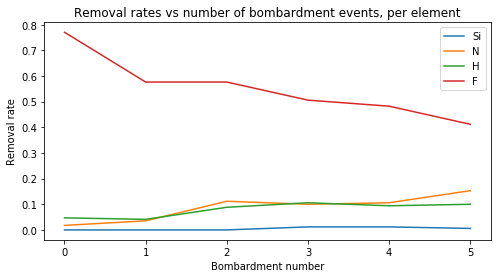

In [26]:
removed_totals = pd.concat([(pd.read_csv("../data%d.csv" % i, index_col=0) != 0)
                            .sum(axis = 1) for i in range(6)], axis = 1)/170
removed_totals.loc[["Si", "N", "H", "F"]].T.plot(figsize = (8,4), title = "Removal rates vs number of bombardment events, per element")
plt.xlabel("Bombardment number")
plt.ylabel("Removal rate")

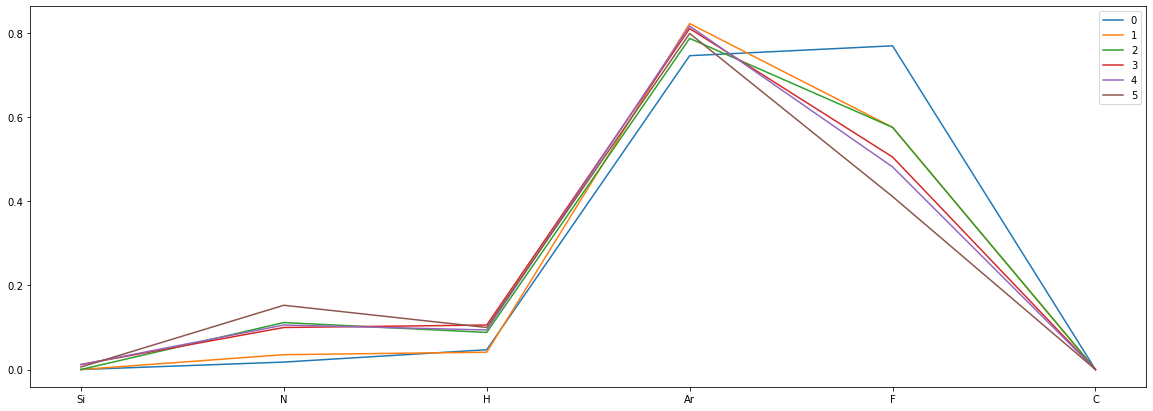

In [27]:
removed_totals.plot()

In [65]:
mask = removedspecies.loc["N"] > 0
HtoN = removedspecies.loc["H"]/removedspecies.loc["N"]
print("Average H/N removal where N removed > 0: ", np.mean(HtoN[mask]))

Average H/N removal where N removed > 0:  1.7467532467532467


In [66]:
removedspecies.loc[:, removedspecies.loc['N'] > removedspecies.loc["H"]]

,5-12
Si,0
N,1
H,0
Ar,1
F,0


In [67]:
removedspecies.loc[:, removedspecies.loc['H'] > 2*removedspecies.loc["N"]]

,7-7,0-14,1-11,9-5,9-11,9-14,7-10,4-13,3-15,4-9,7-6,6-11,7-2,1-12,2-5,6-13,0-6,6-8,9-12,7-3
Si,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
N,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
H,3,1,3,1,1,2,3,3,1,1,1,1,1,1,1,1,1,1,1,2
Ar,0,1,0,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1
F,1,3,0,1,0,2,1,2,2,0,2,2,1,1,2,2,3,2,0,3


In [68]:
removedspecies.loc[:, removedspecies.loc['Si'] > 0]

""
Si
N
H
Ar
F


In [70]:
view(geometries['7-0'])
# view([trimmedgeoms[key] for key in templates.keys()])
# view([templates[key] for key in templates.keys()])

In [60]:
np.all([(len(trimmedgeoms[key]) ==  len(trimmedvelos[key])) for key in trimmedgeoms.keys()])

True

ONLY IF YOU WISH TO SORT:

In [61]:
# outstruct = gen.read_gen("../input.gen")
# order = [atom.index for atom in sorted(outstruct, key = lambda atom: atom.position[2])]

# tempstruct = Atoms(sorted(outstruct, key = lambda atom: atom.position[2]))
# del outstruct[[atom.index for atom in outstruct]]
# outstruct += tempstruct
# outstruct.constraints = FixAtoms(np.arange(80))
# view(outstruct)
# gen.write_gen("../input.gen", outstruct)

In [62]:
# for key in trimmedgeoms.keys():
#     outstruct = trimmedgeoms[key]
#     order = [atom.index for atom in sorted(outstruct, key = lambda atom: atom.position[2])]
#     trimmedvelos[key]["zvals"] = [atom.position[2] for atom in outstruct]
#     trimmedvelos[key] = trimmedvelos[key].sort_values(by = "zvals")
#     trimmedvelos[key] = trimmedvelos[key].drop("zvals", axis = 1)
    
#     tempstruct = Atoms(sorted(outstruct, key = lambda atom: atom.position[2]))
#     del outstruct[[atom.index for atom in outstruct]]
#     outstruct += tempstruct
#     trimmedgeoms[key] = outstruct

In [35]:
for key, geom in trimmedgeoms.items():
    gen.write_gen("../trimmedgeoms/input" + key + ".gen", geom)
for key, v in trimmedvelos.items():
    v.to_csv("../trimmedgeoms/velos" + key, sep = " ", index = False, header = False)

In [110]:
view([trimmedgeoms[key] for key in trimmedgeoms.keys()])

In [19]:
viewkey = '2-4'
view([geometries[viewkey], trimmedgeoms[viewkey], templates[viewkey]])

In [287]:
temp = trimmedgeoms['0-0'].copy()
temp.constraints = FixAtoms(np.arange(80))
view(temp)

In [29]:
# temp =xtl2x2.copy() 
temp.edit()

# MD.out analysis

In [278]:
datadir = "../barebomb.v0.14/quench/" #bare bombardment, v0.13 = 35 eV, .135 = 37.7, .14 = 40.55
mdTemps = []
mdPotential = []
mdTotal = []
for i in os.listdir(datadir):
    if "md" in i:
        mdTemps_i = []
        mdPotential_i  =[]
        mdTotal_i = []
        key = re.search(r"\d+-\d+", i)
        if key:
            key = key.group(0)
            with open(datadir + i, "r") as f:
                for line in f:
                    tempMatch1 = re.search(r"Temperature.* (\d+\.\d+) K$", line)
                    tempMatch2 = re.search(r"Potential.* (-?\d+\.\d+) eV$", line)
                    tempMatch3 = re.search(r"Total.* (-?\d+\.\d+) eV$", line)
                    if tempMatch1:
                        mdTemps_i += [float(tempMatch1.group(1))]
                        if float(tempMatch1.group(1)) > 900:
                            print(key)
                    elif tempMatch2:
                        mdPotential_i += [float(tempMatch2.group(1))]
                    elif tempMatch3:
                        mdTotal_i += [float(tempMatch3.group(1))]

        mdTemps += [mdTemps_i]
        mdTotal += [mdTotal_i]
        mdPotential += [mdPotential_i]


4-15
2-3
3-6
8-13
2-8


In [279]:
runlen = 999
fullrun = lambda x: len(x) >= runlen
mdTemps = list(filter(fullrun, mdTemps))
mdPotential = list(filter(fullrun, mdPotential))
mdTotal = list(filter(fullrun, mdTotal))

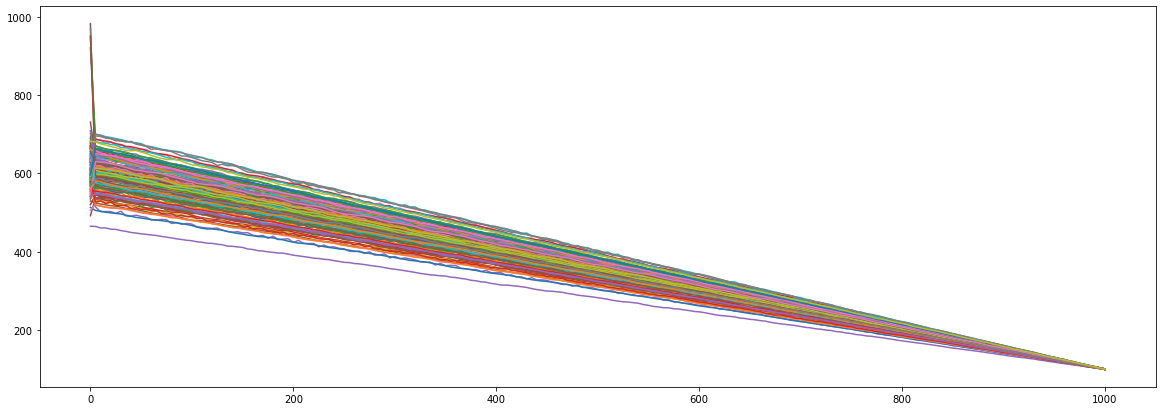

In [280]:
s = 5
for i in mdTemps:
    x = np.arange(len(i), step = s)
    plt.plot(x, i[::s])

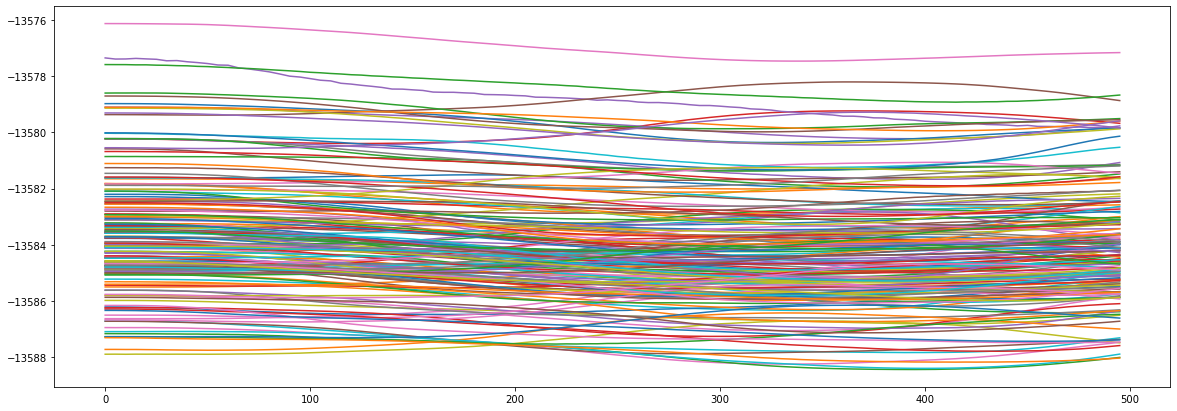

In [43]:
s = 5
for i in mdTotal:
    x = np.arange(len(i), step = s)
    plt.plot(x, i[::s])

# x/y/velocity analysis (for Si removal on modded surface)

Regenerate the velocities used:

In [164]:
randVelos = {key: velos[key].iloc[-1, -1] for key in velos.keys()}
randVelos

{'7-15': -151.0,
 '2-15': -156.0,
 '2-3': -182.0,
 '8-1': -184.0,
 '5-10': -193.0,
 '0-0': -188.0,
 '1-4': -163.0,
 '2-9': -187.0,
 '4-12': -184.0,
 '4-9': -187.0,
 '6-14': -181.0,
 '0-13': -192.0,
 '3-0': -150.0,
 '3-11': -162.0,
 '0-8': -155.0,
 '2-6': -173.0,
 '5-11': -185.0,
 '1-1': -185.0,
 '3-5': -155.0,
 '7-7': -167.0,
 '1-16': -184.0,
 '5-12': -154.0,
 '2-0': -168.0,
 '6-9': -172.0,
 '5-9': -163.0,
 '0-12': -154.0,
 '5-8': -198.0,
 '0-15': -183.0,
 '6-13': -184.0,
 '7-8': -182.0,
 '9-1': -150.0,
 '9-12': -179.0,
 '6-15': -190.0,
 '1-11': -176.0,
 '8-2': -161.0,
 '1-8': -155.0,
 '9-10': -178.0,
 '9-8': -188.0,
 '9-4': -174.0,
 '6-11': -191.0,
 '7-13': -169.0,
 '4-2': -173.0,
 '6-0': -183.0,
 '5-0': -174.0,
 '8-3': -170.0,
 '7-16': -168.0,
 '3-3': -161.0,
 '8-0': -172.0,
 '9-7': -184.0,
 '6-5': -161.0,
 '2-11': -173.0,
 '4-13': -164.0,
 '9-0': -187.0,
 '0-10': -189.0,
 '5-5': -170.0,
 '8-16': -172.0,
 '8-7': -171.0,
 '7-4': -156.0,
 '7-5': -187.0,
 '8-11': -155.0,
 '2-2': -151.0,

Regenerate the coordinates used: 

In [165]:
siPosition = [9.027, 5.362, 13.333] # for hterm surf
# siPosition = [9.021, 5.468, 13.548] # for fterm surf

In [166]:
np.random.seed(429)

ref = gen.read_gen("../geom.out.gen")

num_dirs = 10
runs_per_dir = 17 #4 cores per run, 68 cores on st2 
output_dir = "../inputs/"
randPositions = {}

for d in range(num_dirs):
    for run in range(runs_per_dir):
        
        s = ref.copy()
        zcoord = 4
        offset = 6
        p = np.array(siPosition) + (np.append(np.random.random(2), 0) * offset - offset/2)
        add_adsorbate(s, 'Ar', height =  zcoord, position = p[:2])
        gen.write_gen(output_dir + "input%d-%d.gen" % (d, run), s)
        randPositions["%d-%d" %(d, run)] = s[-1].position

# view([gen.read_gen(output_dir + i) for i in os.listdir(output_dir)])

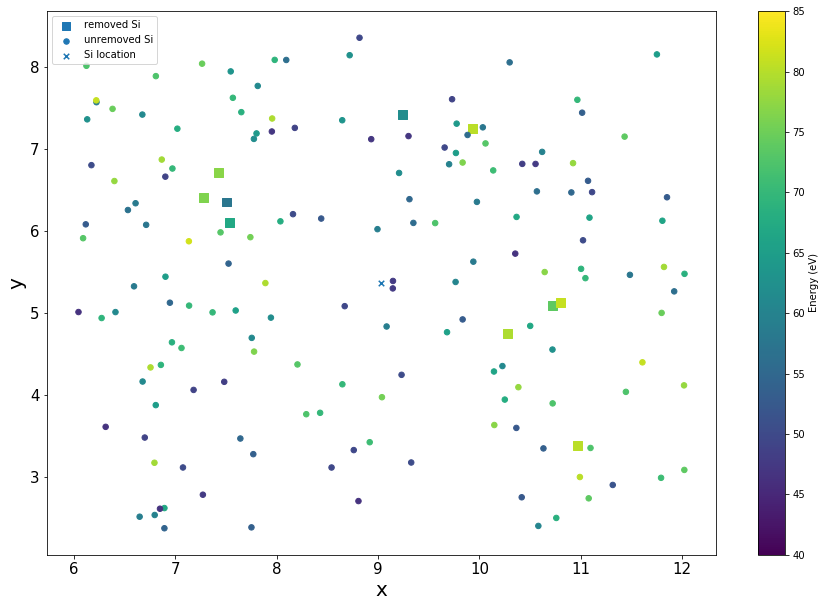

In [214]:
neg = -1 if False else 1
plotPoints = []
plotLabels = []
for key in randVelos.keys():
#     plotPoints += [[randPositions[key][0], randPositions[key][1], randVelos[key]]]
    plotPoints += [[randPositions[key][0], randPositions[key][1], KE(randVelos[key] * 1e-3)]]
    plotLabels += [removedspecies[key]['Si'] > 0]
plotPoints = np.array(plotPoints)

fig = plt.figure(figsize=(15, 10))
# ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)


removed = np.array(plotPoints)[plotLabels]
notremoved = np.array(plotPoints)[~np.array(plotLabels)]
# ax.scatter(plotPoints[:, 0], plotPoints[:, 1], neg * plotPoints[:, 2], c = plotLabels, cmap = 'jet')
# ax.scatter(plotPoints[:, 0], plotPoints[:, 1], c = plotLabels, cmap = 'viridis') 
im1 = ax.scatter(removed[:, 0], removed[:, 1], c = neg * removed[:, 2], 
                 cmap = 'viridis', vmax = 85, vmin = 40, marker = 's', s = 80, label = 'removed Si') 
im2 = ax.scatter(notremoved[:, 0], notremoved[:, 1], c = neg * notremoved[:, 2], 
                 cmap = 'viridis', vmax = 85, vmin = 40, marker = 'o', s = 30, label = 'unremoved Si') 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

ax.scatter(siPosition[0], siPosition[1], 30, marker = 'x', label = "Si location")
fig.colorbar(im1, label = "Energy (eV)")

ax.set_xlabel('x', fontsize = 20)
ax.set_ylabel('y', fontsize = 20)
# ax.set_zlabel('|Velocity| (Å/ps)')

# ax.set_zlabel("Energy (eV)")
plt.legend()

plt.show()

In [212]:
view(ref)

# xx